In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import matplotlib
import logging

import utils as utils
from matplotlib import cm

In [2]:
runname = 'debug_withC_rogers_netcdfBdy1_EB_soliton_withsponge_focus_finey_summer'
datafilepath = '/Volumes/Tan_2024/SUNTANS/NLIW/iwave2024/dongsha/'+runname+'/data_f_1wave/'

# datafilename = 'sun_out.nc_0000.nc'
datafilename = 'sun_sparse.nc_0000.nc'

# path to saved result
resultfilepath = datafilepath+'/results/'
# path to saved figures
outfilepath = '../figure/'
if not os.path.exists(resultfilepath):
    os.mkdir(resultfilepath)
if not os.path.exists(outfilepath):
    os.mkdir(outfilepath)

param_data = {
    "datafilepath": datafilepath,
    "netcdf_filename": datafilename,
            }
param_result = {
    "resultfilepath": resultfilepath,
    "result_filename": 'sun_out_energy_derived.nc',
            }
idx_end = -15

# Read data

In [3]:
data = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_dissp.nc')
data_ = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'])

# Island center & Shoaling depth

In [4]:
lambdaM2=70.1e3
l_sponge = 20e3
L=1.5*lambdaM2+2*l_sponge
W=1.5*lambdaM2

x_c = 2*l_sponge+1.5*lambdaM2/2 
y_c = W/2

In [5]:
depth_top = 4
depth_shoal = 180
depth_bottom = 600-1e-2

# Dissipation

## overhead view

In [6]:
dissip0 = data.dissip0
dissip_prime = data.dissip_prime

In [7]:
# spatially filter dissipation; running mean, binsize = N
N = 10
dissip_prime_filter = dissip_prime[-1,:,:].data.copy()
dissip_0_filter = dissip0[-1,:,:].data.copy()
for i in range(len(data.x)):
    dissip_prime_filter[i,:] = np.convolve(dissip_prime_filter[i,:], np.ones(N)/N, 'same')
    dissip_0_filter[i,:] = np.convolve(dissip_0_filter[i,:], np.ones(N)/N, 'same')
for j in range(len(data.y)):
    dissip_prime_filter[:,j] = np.convolve(dissip_prime_filter[:,j], np.ones(N)/N, 'same')
    dissip_0_filter[:,j] = np.convolve(dissip_0_filter[:,j], np.ones(N)/N, 'same')

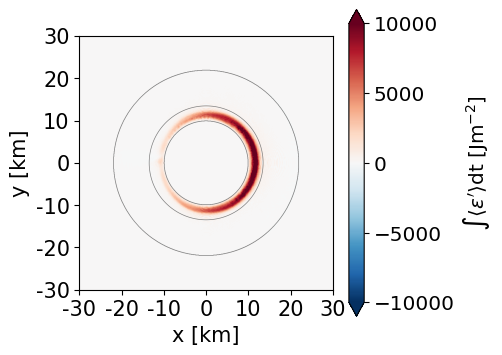

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# im1 = dissip0[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, dissip_prime_filter.T, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle \epsilon'\rangle$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dissip_prime_overhead_summer_f.jpeg", dpi=300)

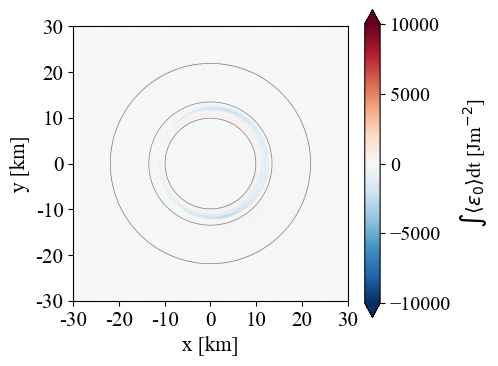

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# im1 = dissip0[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, dissip_0_filter.T, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle \epsilon_0\rangle$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dissip_0_overhead_summer_f.jpeg", dpi=300)

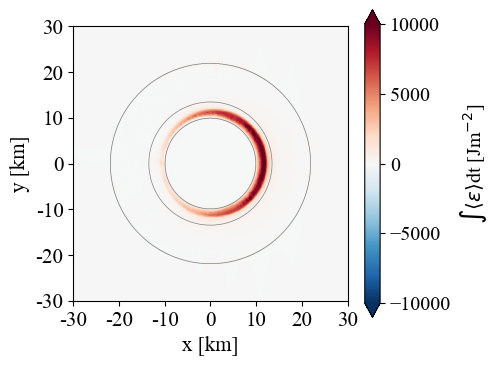

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# im1 = dissip0[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, dissip_prime_filter.T+dissip_0_filter.T, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle \epsilon\rangle$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dissip_all_overhead_summer_f.jpeg", dpi=300)

## area integration

In [11]:
dissip_rate = (dissip0+dissip_prime).differentiate("time",datetime_unit="s")

In [12]:
# change to radial coordinate
dis_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        dis_c[i,j] = np.sqrt((data.x[i].data-x_c)**2+(data.y[j].data-y_c)**2)
        
theta_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        theta_c[i,j] = np.arctan2(data.y[j].data-y_c, data.x[i].data-x_c)

In [13]:
dis_top = np.mean(dis_c[np.where((data_.depth>=depth_top+.1) & (data_.depth.data<=depth_top+2))])
dis_shoal = np.mean(dis_c[np.where((data_.depth>=depth_shoal-1) & (data_.depth.data<=depth_shoal+1))])
dis_bottom = np.mean(dis_c[np.where((data_.depth>=depth_bottom-1) & (data_.depth.data<depth_bottom))])
quadrants_info = {
    "r_quad": np.array([dis_shoal,dis_bottom]),
    "quadrants": ['east', 'north', 'west', 'south'],
    "theta_quad": [[-45, 45], [45, 135], [135, -135], [-135, -45]]
            }

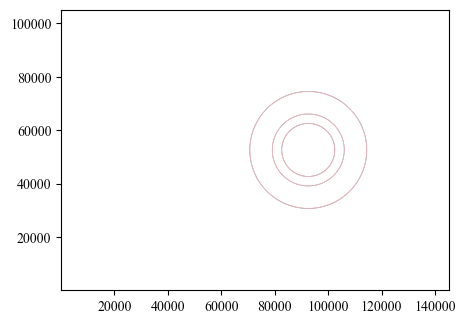

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)
ax.contour(data.x.data, data.y.data, dis_c.T, levels = [dis_top, dis_shoal, dis_bottom], colors='pink', linewidths=.5)
ax.set_aspect('equal')

In [15]:
# mask out data outside of the rings  
mask_ring = (dis_c>=dis_top) & (dis_c<quadrants_info["r_quad"][0])
mask_ring_east = mask_ring & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_north = mask_ring & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_west = mask_ring & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_south = mask_ring & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

dissp_rate_int_inner = np.zeros((4, len(data.time)))
dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_east] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_inner[0,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_north] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_inner[1,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_west] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_inner[2,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_south] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_inner[-1,:] = dissp_rate_out_.integrate('y')

In [16]:
# mask out data outside of the rings  
mask_ring = (dis_c>=quadrants_info["r_quad"][0]) & (dis_c<quadrants_info["r_quad"][-1])
mask_ring_east = mask_ring & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_north = mask_ring & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_west = mask_ring & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_south = mask_ring & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

dissp_rate_int_outter = np.zeros((4, len(data.time)))
dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_east] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_outter[0,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_north] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_outter[1,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_west] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_outter[2,:] = dissp_rate_out_.integrate('y')

dissp_rate_ = dissip_rate.copy()
for i in range(len(dissp_rate_.time)):
    var_ = dissp_rate_[i,:,:].data
    var_[~mask_ring_south] = 0
    dissp_rate_[i,:,:] = var_
dissp_rate_out_ = dissp_rate_.integrate('x')
dissp_rate_int_outter[-1,:] = dissp_rate_out_.integrate('y')

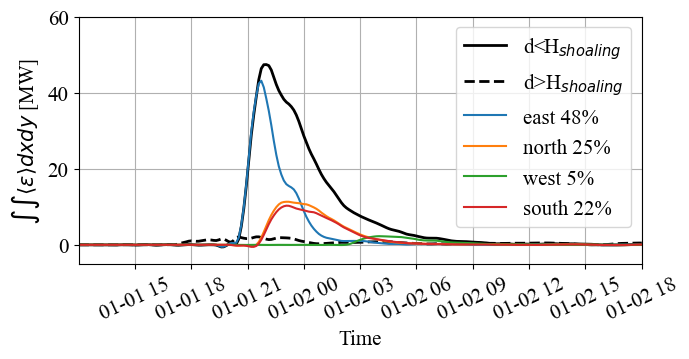

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
ax.plot(data.time, np.sum(dissp_rate_int_inner*1e-6,axis=0), c='k', lw=2, label='d<H$_{shoaling}$')
ax.plot(data.time, np.sum(dissp_rate_int_outter*1e-6,axis=0), c='k', ls='--', lw=2, label='d>H$_{shoaling}$')
for i in range(4):
    ax.plot(data.time, dissp_rate_int_inner[i,:]*1e-6, label=quadrants_info['quadrants'][i]+' '+str(int(np.round(np.trapz(dissp_rate_int_inner[i,:])/np.trapz(np.sum(dissp_rate_int_inner,axis=0))*100)))+'%')
ax.legend(fontsize=15, ncol=1, loc='upper right')
ax.set_ylim([-5,60])
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle \epsilon\rangle dxdy$ [MW]", fontsize=15)
# ax.set_ylabel(r"$\int\int(\overline{\epsilon}+\overline{D})dxdy$ [W]", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
plt.tight_layout()
# for idx_t in np.arange(20,40+1,5):
#     ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-65, 5], '.5')
# for idx_t in np.arange(45,80,5):
#     ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-65, 5], 'pink')
plt.rcParams["font.family"] = "Times New Roman"  

plt.savefig(outfilepath+ f"dissp_rate_areaintegrate_quadrants_summer_f.jpeg", dpi=300)

# Bottom Drag

## overhead view

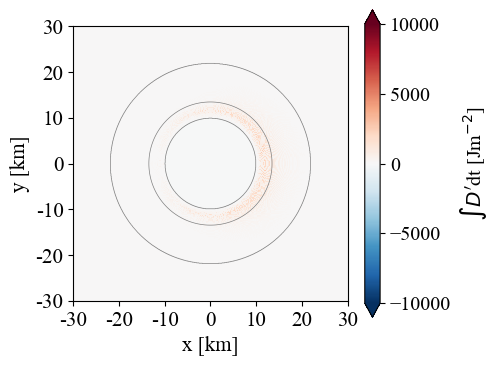

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = data_.D_prime[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int D'$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"drag_prime_overhead_summer_f.jpeg", dpi=300)

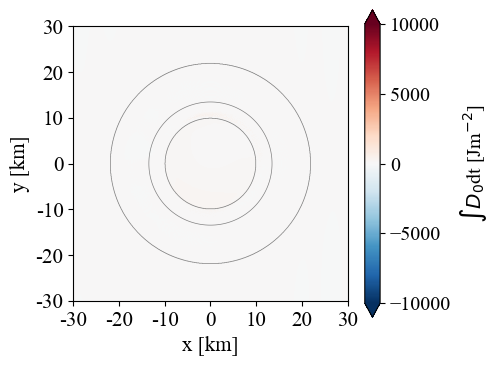

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = data_.D0[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int D_0$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"drag_0_overhead_summer_f.jpeg", dpi=300)

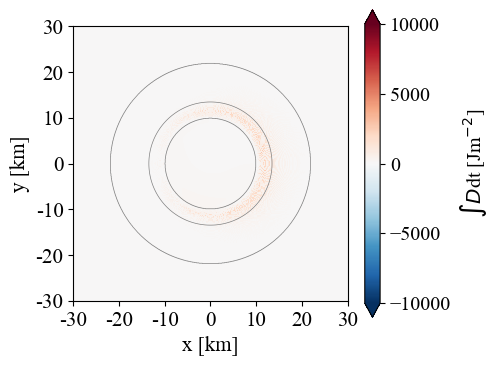

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = (data_.D0[-1,:,:]+data_.D_prime[-1,:,:]).T.plot.pcolormesh(ax=ax, vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r, add_colorbar=False)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int D$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"drag_all_overhead_summer_f.jpeg", dpi=300)

# Dissipation + Bottom Drag

## overhead view

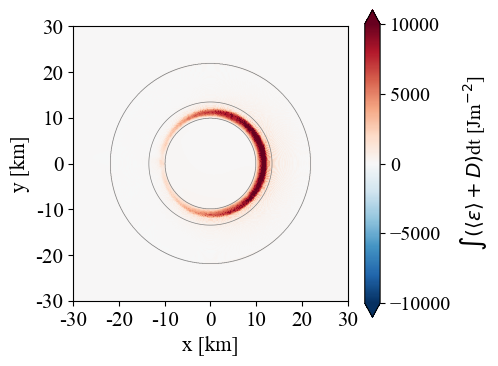

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = ax.pcolormesh(data.x.data, data.y.data, dissip_prime_filter.T+dissip_0_filter.T+data_.D0[-1,:,:].data.T+data_.D_prime[-1,:,:].data.T
                    , vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r)

cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int(\langle\epsilon\rangle+D)$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"sum_dissip_drag_all_overhead_summer_f.jpeg", dpi=300)

# dEk'/dt+dEp'/dt

In [22]:
time_1 = np.arange(10,60+1,10)
time_2 = np.arange(70,130+1,10)

## overhead view

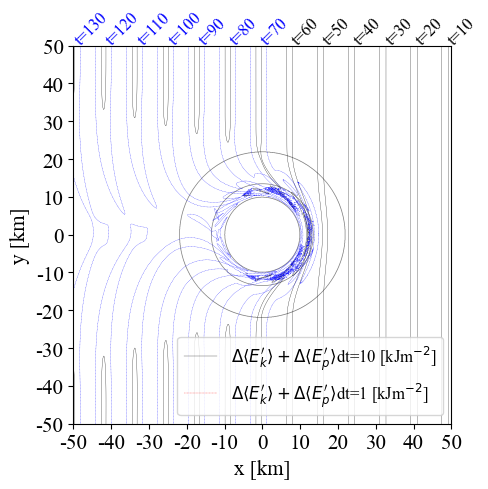

In [23]:
from matplotlib import cm
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
# im1 = ax.pcolormesh(data.x.data, data.y.data, dissip_prime_filter.T+dissip_0_filter.T+data_.D0[-1,:,:].data.T+data_.D_prime[-1,:,:].data.T
#                     , vmax=1e4, vmin=-1e4, cmap=cm.RdBu_r)
# cb1 = plt.colorbar(im1, location='right', extend='both')
# cb1.set_label(label=r"$\int D$dt [Jm$^{-2}$]", size='x-large')
# cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

for idx_t in time_1:
    (data_.dEk_prime[idx_t,:,:]+data_.dEp_prime[idx_t,:,:]).T.plot.contour(levels=np.array([1e4]), colors='k', linewidths=.2)
    ax.text(data.x[np.argmax((data_.dEk_prime[idx_t,:,:]+data_.dEp_prime[idx_t,:,:])[:,-1].data)].data, 50e3*2+3e3, f't={idx_t}', rotation = 45, fontsize=12)
for idx_t in time_2:
    (data_.dEk_prime[idx_t,:,:]+data_.dEp_prime[idx_t,:,:]).T.plot.contour(levels=np.array([1e4]), colors='k', linewidths=.2)
    (data_.dEk_prime[idx_t,:,:]+data_.dEp_prime[idx_t,:,:]).T.plot.contour(levels=np.array([.1e4]), linestyles='dashed', colors='b', linewidths=.2)
    ax.text(data.x[np.argmax((data_.dEk_prime[idx_t,:,:]+data_.dEp_prime[idx_t,:,:])[:,-1].data)].data, 50e3*2+3e3, f't={idx_t}', c='b', rotation = 45, fontsize=12)
ax.plot([100,100],[100,100], c='k', lw=.2, label=r"$\Delta\langle E_k'\rangle+\Delta\langle E_p'\rangle$dt=10 [kJm$^{-2}$]")
ax.plot([100,100],[100,100], linestyle='--', c='r', lw=.2, label=r"$\Delta\langle E_k'\rangle+\Delta\langle E_p'\rangle$dt=1 [kJm$^{-2}$]")

# ax.set_xlim([x_c-30000, x_c+30000])
# ax.set_ylim([y_c-30000, y_c+30000])
# ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
# ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
# ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
# ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_xlim([x_c-50000, x_c+50000])
ax.set_ylim([y_c-50000, y_c+50000])
ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.legend(fontsize=12, loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dEk_dEp_overhead_with_time_summer_f.jpeg", dpi=300)

## area integration

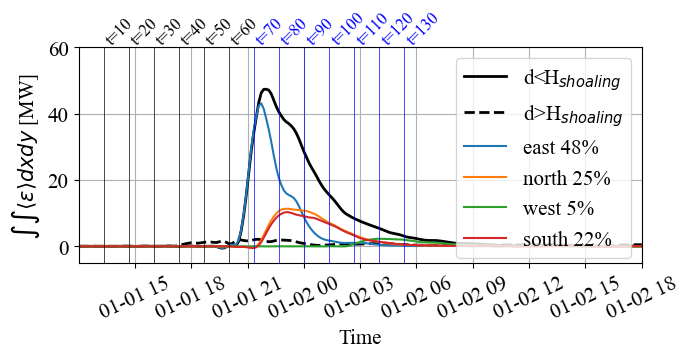

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
ax.plot(data.time, np.sum(dissp_rate_int_inner*1e-6,axis=0), c='k', lw=2, label='d<H$_{shoaling}$')
ax.plot(data.time, np.sum(dissp_rate_int_outter*1e-6,axis=0), c='k', ls='--', lw=2, label='d>H$_{shoaling}$')
for i in range(4):
    ax.plot(data.time, dissp_rate_int_inner[i,:]*1e-6, label=quadrants_info['quadrants'][i]+' '+str(int(np.round(np.trapz(dissp_rate_int_inner[i,:])/np.trapz(np.sum(dissp_rate_int_inner,axis=0))*100)))+'%')
ax.legend(fontsize=15, ncol=1, loc='upper right')
ax.set_ylim([-5,60])
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle \epsilon\rangle dxdy$ [MW]", fontsize=15)
# ax.set_ylabel(r"$\int\int(\overline{\epsilon}+\overline{D})dxdy$ [W]", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
for idx_t in time_1:
    ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-5, 60], 'k', lw=.5)
    ax.text(data.time[idx_t].data, 61, f't={idx_t}', rotation = 45, fontsize=12)
for idx_t in time_2:
    ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-5, 60], 'b', lw=.5)
    ax.text(data.time[idx_t].data, 61, f't={idx_t}', c='b', rotation = 45, fontsize=12)
plt.rcParams["font.family"] = "Times New Roman"  
plt.tight_layout()

plt.savefig(outfilepath+ f"dissp_rate_areaintegrate_quadrants_with_t_summer_f.jpeg", dpi=300)

In [25]:
c = 1.7154
dt = (data.time.data-data.time[0].data).astype('int')*1e-9
distance_c = x_c - (L-c*dt)

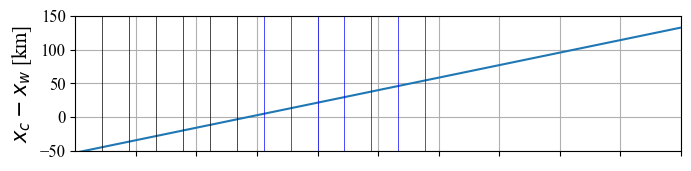

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 1.7))
ax.plot(data.time, distance_c*1e-3)
ax.set_ylim([-50,150])
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel(r"$x_c-x_w$ [km]", fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('')
ax.grid()
for idx_t in time_1:
    ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-50, 150], 'k', lw=.5)
    # ax.text(data.time[idx_t].data, 61, f't={idx_t}', rotation = 45, fontsize=12)
for idx_t in time_2:
    ax.plot([data.time[idx_t].data, data.time[idx_t].data], [-50, 150], 'b', lw=.5)
    # ax.text(data.time[idx_t].data, 61, f't={idx_t}', c='b', rotation = 45, fontsize=12)
plt.rcParams["font.family"] = "Times New Roman"  
plt.tight_layout()

plt.savefig(outfilepath+ f"dis_dissp_rate_areaintegrate_quadrants_with_t_summer_f.jpeg", dpi=300)